In [1]:
from utils import *
from MySolution import MyClassifier, MyClustering, MyLabelSelection


Synthetic data shape:  (1000, 2) (1000,)


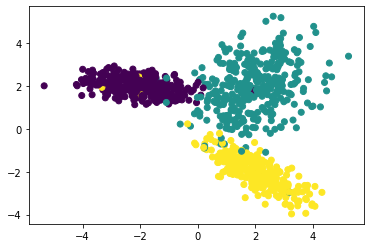

In [6]:
# Get datasets
syn_data = prepare_synthetic_data()
print("Synthetic data shape: ", syn_data['trainX'].shape, syn_data['trainY'].shape)

plt.scatter(syn_data['trainX'][:, 0], syn_data['trainX'][:, 1], c=syn_data['trainY'])

MNIST data shape:  (1000, 784) (1000,)


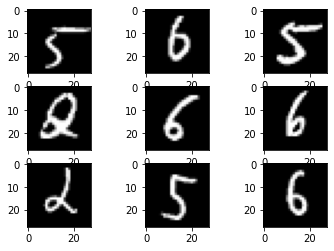

In [4]:
mnist_data = prepare_mnist_data()
print("MNIST data shape: ", mnist_data['trainX'].shape, mnist_data['trainY'].shape)

for i in range(9):	
    plt.subplot(330 + 1 + i)
    plt.imshow(mnist_data['trainX'][i].reshape(28,28), cmap='gray')
plt.show()

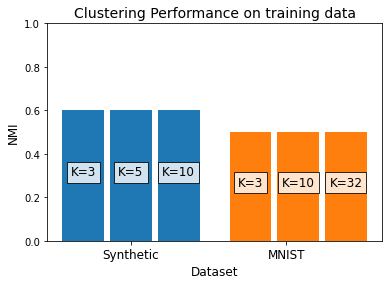

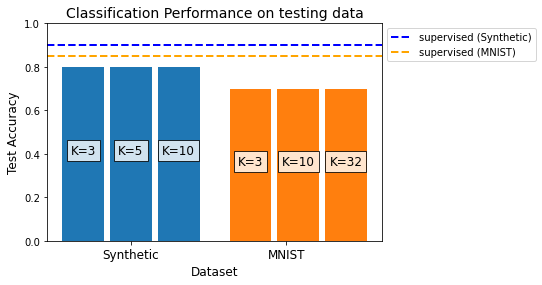

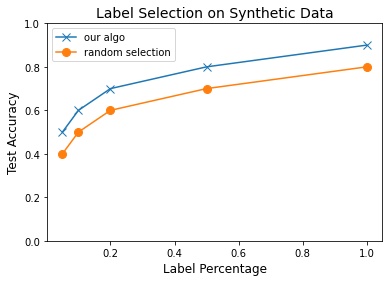

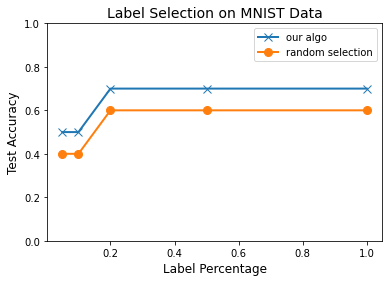

In [5]:
## TODO: Implement your solution and store the results in the following dictionaries
## Please note that the below values are given as an example to show the format, 
## you need to replace them with your values :)

result1 = {'synthetic_test_accuracy':0.9, 'mnist_test_accuracy':0.85}

result2 = {'synthetic':{'K':[3, 5, 10], 'clustering_nmi':[0.6,0.6,0.6], 'classification_accuracy':[0.8,0.8,0.8]},
            'mnist':{'K':[3, 10, 32], 'clustering_nmi':[0.5,0.5,0.5], 'classification_accuracy':[0.7,0.7,0.7]}}
                                
result3 = {'synthetic': {'label_percentage':[0.05,0.1,0.2,0.5,1], 'test_accuracy(our algo)':[0.5,0.6,0.7,0.8,0.9], 'test_accuracy(random)':[0.4,0.5,0.6,0.7,0.8]},
            'mnist': {'label_percentage':[0.05,0.1,0.2,0.5,1], 'test_accuracy(our algo)':[0.5,0.5,0.7,0.7,0.7], 'test_accuracy(random)':[0.4,0.4,0.6,0.6,0.6]}}


plot_result(result1, result2, result3)